In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dt
import math
import itertools as it
from matplotlib import pyplot as plt
from scipy.special import factorial
from scipy.stats import norm, poisson, gamma, probplot, ks_2samp, kstest
from scipy.optimize import minimize, Bounds
from scipy.integrate import quad
from shapely.geometry import Point, Polygon

C:\Users\souza.daniel_ifood\anaconda3\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 12

In [4]:
def amostra_agrupada(df, grupo, tam, n_min, n_max, semente):
    df_filtrado = df.groupby(grupo).filter(lambda x: (len(x) >= n_min) & (len(x) <= n_max))
    amostra_df_filtrado = pd.Series(df_filtrado[grupo].unique()).sample(tam, random_state=semente)
    
    return df[df[grupo].isin(amostra_df_filtrado)]


def plot_agrupado(df, grupo, x, y, agr, cols):
    grps = df.groupby(grupo, sort=False)
    rows = int(grps.ngroups / cols)
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(18, 4 * rows))

    for (chv, grp), ax in zip(grps, axs.ravel()):
        grp.groupby(x).agg(pedidos=(y, agr)).plot(kind='bar', legend='', xlabel='', ax=ax)
        ax.set_title(grp[grupo].unique()[0])

In [5]:
def Y_t(x, T):
    return len(T[T >= x])


def epanechnikov(x):
    return 3 / 4 * (1 - x ** 2) if np.abs(x) <= 1 else np.zeros(1)

    
def alfa_t(x, T, b, K=norm.pdf):
    b = np.array([b]) if not isinstance(b, np.ndarray) else b
    n = len(T)
    K_t = [K((x - Ti) / b) / Y_t(Ti, T) for i, Ti in enumerate(T)]
    return np.sum(K_t) / b


def Lambda_t(x, T, b, K=norm.pdf):
    return alfa_t(x, T, b, K) * Y_t(x, T)


def A_t(x, T, b, K=norm.pdf):
    return quad(Lambda_t, 0, x, (T, b, K))


def A_t_Riemann(T, b, K=norm.pdf, h=0.0001):
    oT = np.insert(np.sort(T), 0, 0)
    return oT[1:], h * np.cumsum([np.sum([Lambda_t(x, T, b, K) for x in np.arange(i, j, h)]) for i, j in zip(oT[:-1], oT[1:])])


def cv_loglike(b, x, K=norm.pdf):
    n = len(x)
    total_loglike = 0
    
    for i in range(n):
        x_sem_i = np.delete(x, i)
        xi = x[i]
        alfa_fxi = alfa_t(xi, x_sem_i, b, K)
        if alfa_fxi <= 0: continue
        total_loglike += np.log(alfa_fxi)
        
    return -total_loglike


def b_otimo_cv(f, ini, params, lims):
    return minimize(f, ini, params, bounds=lims)['x']

### Conjunto de dados

In [6]:
pedidos = pd.read_csv('./Dados/Amostra_Pedidos.csv', parse_dates=['Início Preparo', 'Início Entrega', 'Término Entrega'])

In [7]:
pedidos = pedidos[(pedidos['Início Preparo'] > dt.datetime(2023, 1, 10)) & (pedidos['Início Preparo'] < dt.datetime(2023, 1, 11))]

In [8]:
pedidos_por_estabelecimento = pedidos['Estabelecimento'].value_counts().reset_index()
estabelecimentos_validos = pedidos_por_estabelecimento[pedidos_por_estabelecimento['Estabelecimento'] >= 10]['index'].values
pedidos = pedidos[pedidos['Estabelecimento'].isin(estabelecimentos_validos)]

In [9]:
rest_grande = amostra_agrupada(pedidos[pedidos['Tipo Entrega'] == 'IFOOD'], 'Estabelecimento', 1, 101, 200, 1234)
rest_grande['Tam Rest'] = '100-200 pedidos'
rest_medio = amostra_agrupada(pedidos[pedidos['Tipo Entrega'] == 'IFOOD'], 'Estabelecimento', 1, 51, 100, 1234)
rest_medio['Tam Rest'] = '50-100 pedidos'
rest_pequeno = amostra_agrupada(pedidos[pedidos['Tipo Entrega'] == 'IFOOD'], 'Estabelecimento', 1, 30, 50, 1234)
rest_pequeno['Tam Rest'] = '30-50 pedidos'
amostra_rests = pd.concat([rest_pequeno, rest_medio, rest_grande])
amostra_rests['Horário Preparo'] = amostra_rests['Início Preparo'].dt.floor('1h').dt.strftime('%H:%M')

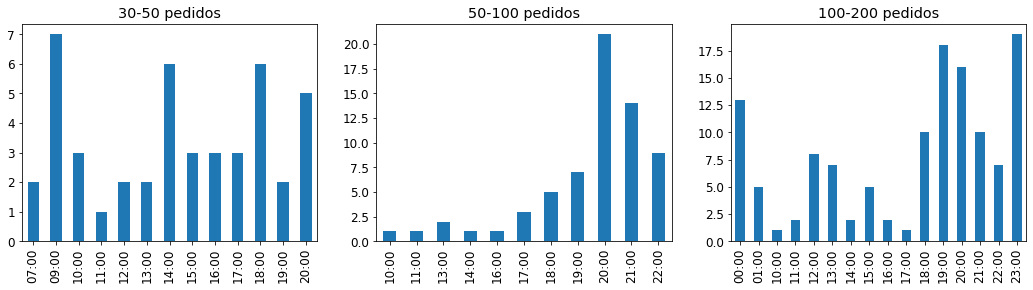

In [10]:
plot_agrupado(amostra_rests, 'Tam Rest', 'Horário Preparo', 'Ident. Pedido', 'count', 3)

### Cálculos taxa de chegada

In [ ]:
grps = amostra_rests.groupby('Tam Rest', sort=False)
t0 = dt.datetime(2023, 1, 10)

Nt = []
for chv, grp in grps:
    T = (grp['Início Preparo'] - t0).dt.total_seconds().values / 86400
    b = b_otimo_cv(cv_loglike, 1, (T, norm.pdf), Bounds(0.0001, float('inf')))
    alfas_t = np.array([alfa_t(t, T, b) for t in T])
    As_t = A_t_Riemann(T, b)
    Nt.append({
        'Estab': chv,
        'b': b,
        'T': T,
        'alfa': alfas_t,
        'A': As_t
    })

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))

for N, ax in zip(Nt, axs.ravel()):
    ax.plot(N['A'][0], N['A'][1], label='Estimado')
    ax.plot(*list(zip(*np.array([(t, len(N['T'][N['T'] <= t])) for t in np.sort(N['T'])]))), label='Empírico')
    ax.set_title(N['Estab'])
    ax.legend()
    tks = ax.get_xticks()
    ax.set_xticklabels([(dt.datetime(2023, 1, 10) + dt.timedelta(seconds=int(t * 86400))).strftime('%H:%M') for t in tks])

In [ ]:
for N in Nt:
    emp = np.array([len(N['T'][N['T'] <= t]) for t in np.sort(N['T'])])
    est = N['A'][1]
    print(N['Estab'], round(ks_2samp(emp, est).pvalue, 4))

In [ ]:
pedidos_rests = pedidos.groupby('Estabelecimento').agg(pedidos_rest=('Ident. Pedido', 'count')).reset_index()
pedidos_rests['Tam Rest'] = pedidos_rests['pedidos_rest'].apply(lambda x: '>200' if x > 200 else '100-200' if x >= 100 else '50-100' if x >= 50 else '30-50' if x >=30 else '10-30')
pedidos = pedidos.merge(pedidos_rests, on='Estabelecimento')

In [ ]:
grps = pedidos.groupby('Estabelecimento')
NtT = []
for chv, grp in grps:
    print(chv)
    T = (grp['Início Preparo'] - t0).dt.total_seconds().values / 86400
    b = b_otimo_cv(cv_loglike, 1, (T, epanechnikov), Bounds(0.0001, float('inf')))
    As_t = A_t_Riemann(T, b)
    NtT.append({'Est': chv, 'Tam': grp['Tam Rest'].unique()[0], 'T': T, 'b': b, 'A': As_t})

import json

def conversor(x):
    if hasattr(x, 'tolist'):
        return x.tolist()
    raise TypeError(x)
    
with open('./temp_json', 'w') as arquivo:
    arquivo.write(json.dumps(NtT, indent=4, default=conversor))

In [ ]:
with open('./temp_json') as arquivo:
    NtT_json = np.array(json.loads(arquivo.read()))

In [ ]:
pvalues = []
for N in NtT:
    emp = np.array([len(N['T'][N['T'] <= t]) for t in np.sort(N['T'])])
    est = N['A'][1]
    pvalues.append({'Tam': N['Tam'], 'pvalue': ks_2samp(emp, est).pvalue})

In [ ]:
df_pvalues = pd.DataFrame(pvalues)
df_pvalues['c'] = 'c'

In [ ]:
df_pvalues.groupby('Tam').apply(lambda x: round((x.pvalue > 0.05).sum() / x.pvalue.count(), 4))

In [11]:
def distancia(lat1, lon1, lat2, lon2):
    return math.acos(
        math.sin(math.radians(lat1)) * math.sin(math.radians(lat2)) + 
        math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(lon1) - math.radians(lon2))
    ) * 6371.

### Cálculo Tempos de Serviço

In [20]:
pedidos['Distancia'] = pedidos.apply(lambda x: distancia(x['Lat Cliente'], x['Lon Cliente'], x['Lat Estab.'], x['Lon Estab.']), axis=1)

In [21]:
def t0(d0, v0):
    return d0 / v0

In [22]:
pdd_terc = pedidos[pedidos['Tipo Entrega'] == 'MERCHANT']

In [23]:
pdd_terc['TP'] = 3
pdd_terc['Ttau'] = pdd_terc['Distancia'] / 25 * 60
pdd_terc['TC'] = pdd_terc['Ttau'] + pdd_terc['TP']
pdd_terc['d_TC'] = pdd_terc['TC'].apply(lambda x: math.floor(x)) + 1

C:\Users\souza.daniel_ifood\AppData\Local\Temp\ipykernel_16920\1983071303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdd_terc['TP'] = 3
C:\Users\souza.daniel_ifood\AppData\Local\Temp\ipykernel_16920\1983071303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdd_terc['Ttau'] = pdd_terc['Distancia'] / 25 * 60
C:\Users\souza.daniel_ifood\AppData\Local\Temp\ipykernel_16920\1983071303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [24]:
pdd_prim = pedidos[pedidos['Tipo Entrega'] == 'IFOOD']

In [25]:
pdd_prim['TC'] = pdd_prim.apply(lambda x: (x['Término Entrega'] - x['Início Entrega']).total_seconds()  / 60, axis=1)
pdd_prim['d_TC'] = pdd_prim.apply(lambda x: math.floor(x['TC']) + 1, axis=1)

C:\Users\souza.daniel_ifood\AppData\Local\Temp\ipykernel_16920\1573679596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdd_prim['TC'] = pdd_prim.apply(lambda x: (x['Término Entrega'] - x['Início Entrega']).total_seconds()  / 60, axis=1)
C:\Users\souza.daniel_ifood\AppData\Local\Temp\ipykernel_16920\1573679596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdd_prim['d_TC'] = pdd_prim.apply(lambda x: math.floor(x['TC']) + 1, axis=1)


In [26]:
rests_cross = amostra_rests[['Tam Rest', 'Estabelecimento', 'Lat Estab.', 'Lon Estab.']].drop_duplicates().merge(pdd_prim[['Estabelecimento', 'Lat Estab.', 'Lon Estab.']].drop_duplicates(), how='cross')
rests_cross = rests_cross[rests_cross['Estabelecimento_x'] != rests_cross['Estabelecimento_y']]
rests_cross['distancia_rests'] = rests_cross.apply(lambda x: distancia(x['Lat Estab._x'], x['Lon Estab._x'], x['Lat Estab._y'], x['Lon Estab._y']), axis=1)
rests_proximos = rests_cross[rests_cross['distancia_rests'] <= 2]

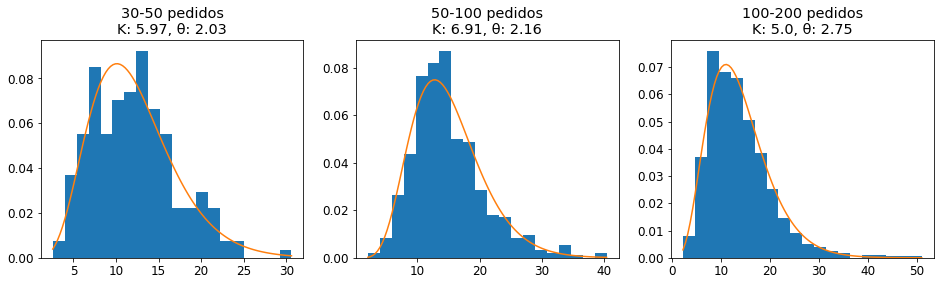

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
grp_estabs_prox = rests_proximos.groupby('Tam Rest', sort=False)

for (chv, grp), ax in zip(grp_estabs_prox, axs.ravel()):
    pdds_proximos = grp.merge(pdd_prim, left_on='Estabelecimento_y', right_on='Estabelecimento')
    a, l, b = gamma.fit(pdds_proximos['TC'].values, floc=0)
    ax.hist(pdds_proximos['TC'].values, bins=20, density=True)
    x = np.linspace(*pdds_proximos['TC'].agg(['min', 'max']), 100)
    ax.plot(x, gamma.pdf(x, a, loc=0, scale=b))
    ax.set_title('{0}\nK: {1}, θ: {2}'.format(chv, round(a, 2), round(b, 2)))

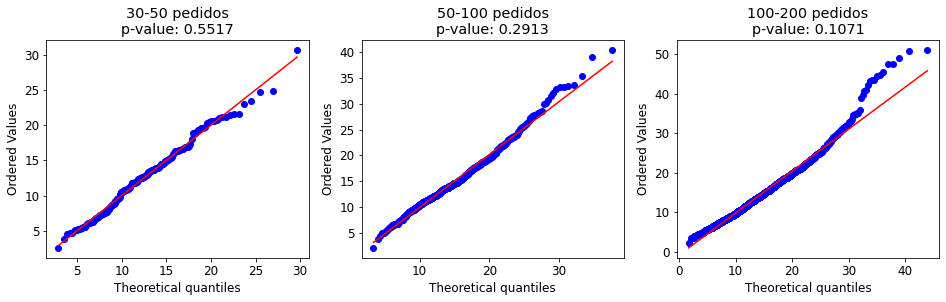

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
grp_estabs_prox = rests_proximos.groupby('Tam Rest', sort=False)

for (chv, grp), ax in zip(grp_estabs_prox, axs.ravel()):
    pdds_proximos = grp.merge(pdd_prim, left_on='Estabelecimento_y', right_on='Estabelecimento')
    a, l, b = gamma.fit(pdds_proximos['TC'].values, floc=0)
    probplot(pdds_proximos['TC'].values, (a, 0, b), 'gamma', fit=True, plot=ax)
    ax.set_title(chv)
    ax.set_title('{0}\np-value: {1}'.format(chv, round(kstest(pdds_proximos['TC'].values, 'gamma', (a, l, b)).pvalue, 4)))

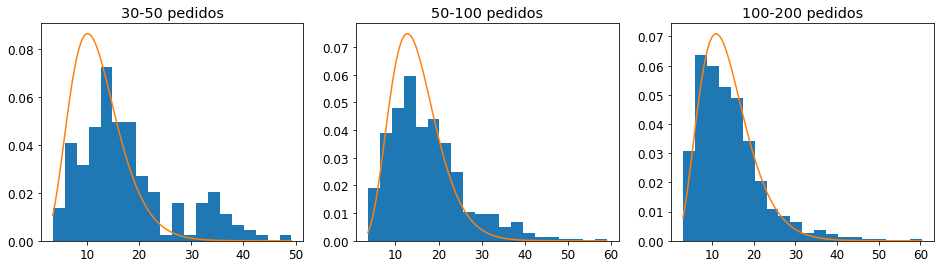

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
grp_estabs_prox = rests_proximos.groupby('Tam Rest', sort=False)

for (chv, grp), ax in zip(grp_estabs_prox, axs.ravel()):
    pdds_proximos = grp.merge(pdd_prim, left_on='Estabelecimento_y', right_on='Estabelecimento')
    a, _, b = gamma.fit(pdds_proximos['TC'].values, floc=0)
    pdds_proximos['TC'] = pdds_proximos['Distancia'] / 10 * 60 + 3
    ax.hist(pdds_proximos['TC'].values, bins=20, density=True)
    
    x = np.linspace(*pdds_proximos['TC'].agg(['min', 'max']), 100)
    ax.plot(x, gamma.pdf(x, a, loc=0, scale=b))
    ax.set_title('{0}'.format(chv))

### Cálculo L

In [ ]:
amostra_rests['Distancia'] = amostra_rests.apply(lambda x: distancia(x['Lat Cliente'], x['Lon Cliente'], x['Lat Estab.'], x['Lon Estab.']), axis=1)

In [ ]:
max_dists_amostra = amostra_rests.groupby(['Tam Rest', 'Estabelecimento', 'Lat Estab.', 'Lon Estab.'], sort=False).agg(max_dist=('Distancia', 'max')).reset_index()

In [ ]:
max_dists_amostra['max_dist'] = max_dists_amostra['max_dist'].apply(lambda x: math.ceil(x))

In [ ]:
fortaleza = gpd.read_file('Dados_ini/Densidade_Populacional_por_Bairros.zip')

In [ ]:
def arred_baixo(num, dec):
    return math.floor(num * 10 ** dec) / 10 ** dec

In [ ]:
def fazer_grade(x_min, y_min, x_max, y_max, p):
    return [(round(x, 3), round(y, 3)) for x in np.arange(x_min - p, x_max + p, p) for y in np.arange(y_min - p, y_max + p, p)]

In [ ]:
x_min, y_min, x_max, y_max = (arred_baixo(b, 3) for b in fortaleza.geometry.unary_union.bounds)

In [ ]:
grade_completa = fazer_grade(x_min, y_min, x_max, y_max, 0.001)

In [ ]:
plt.scatter(*list(zip(*grade_completa)))

In [ ]:
df_grade_completa = pd.DataFrame(grade_completa, columns=['lon', 'lat'])

In [ ]:
raio_entrega_amostra = max_dists_amostra.merge(df_grade_completa, how='cross')

In [ ]:
raio_entrega_amostra['Distancia'] = raio_entrega_amostra.apply(lambda x: distancia(x['lat'], x['lon'], x['Lat Estab.'], x['Lon Estab.']), axis=1)

In [ ]:
raio_entrega_amostra = raio_entrega_amostra[raio_entrega_amostra['Distancia'] <= raio_entrega_amostra['max_dist']]

In [ ]:
raio_entrega_amostra = gpd.GeoDataFrame(raio_entrega_amostra, geometry=gpd.points_from_xy(raio_entrega_amostra['lon'], raio_entrega_amostra['lat']))

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
grp_raios_entrega = raio_entrega_amostra.groupby('Tam Rest', sort=False)

for (chv, grp), ax in zip(grp_raios_entrega, axs.ravel()):
    fortaleza.dissolve().plot(color='lightblue', label='Cidade', ax=ax)
    gpd.sjoin(grp, fortaleza.dissolve(), 'inner', 'within').plot(color='blue', label='Raio', ax=ax)
    ax.scatter(grp['Lon Estab.'], grp['Lat Estab.'], color='red', label='Estab.')
    ax.legend(loc=1)
    ax.set_title('{0}\nL={1}'.format(chv, len(grp)))

### Simulação de fila

In [30]:
teste = amostra_rests[amostra_rests['Estabelecimento'] == 635536]

In [12]:
def estim_b(df, t0, chv, uid, ini):
    df = df[df[chv] == uid]
    T = (df[ini] - t0).dt.total_seconds().values / 86400
    b = b_otimo_cv(cv_loglike, 1, (T, norm.pdf), Bounds(0.0001, float('inf')))
    return b

In [13]:
def estim_param_tx_chegada(df, chv, uid, ini, t0, t, b, K=norm.pdf):
    df = df[df[chv] == uid]
    t_dec = (t - t0).total_seconds() / 86400
    T = (df[ini] - t0).dt.total_seconds().values / 86400
    a = alfa_t(t_dec, T, b, K)
    return a

In [14]:
def simula_entradas_fila(lamb, n):
    return poisson.rvs(lamb, size=n)

In [15]:
def prob_entrada_fila(x, lamb):
    return poisson.pmf(x, lamb)[0]

In [35]:
b = estim_b(pedidos, dt.datetime(2023, 1, 10), 'Estabelecimento', 635536, 'Início Entrega')
lamb = estim_param_tx_chegada(pedidos, 'Estabelecimento', 635536, 'Início Entrega', dt.datetime(2023, 1, 10), dt.datetime(2023, 1, 10, 12, 52, 35), b)
simula_entradas_fila(lamb, 1)

array([3], dtype=int64)

In [16]:
def estim_params_tempo_servico(df, chv, uid, tp, adm, lat, lon, ini, fim, max_dist):
    df_estab = df[df[chv] == uid][[chv, lat, lon]].drop_duplicates()
    df_prox = df_estab.merge(df[df[tp] == adm], how='cross')
    df_prox['d'] = df_prox.apply(lambda x: distancia(x[lat+'_x'], x[lon+'_x'], x[lat+'_y'], x[lon+'_y']), axis=1)
    df_prox = df_prox[(df_prox['d'] <= max_dist) & (df_prox[chv+'_x'] != df_prox[chv+'_y'])]
    df_prox['TC'] = df_prox.apply(lambda x: (x[fim] - x[ini]).total_seconds() / 60, axis=1)
    k, l, theta = gamma.fit(df_prox['TC'].values, floc=0)
    return k, theta

In [17]:
def simula_tempo_servico_discreto(n, k, theta):
    return math.ceil(gamma.rvs(k, loc=0, scale=theta, size=n)[0])

In [18]:
def prob_tempo_servico(x, k, theta):
    return gamma.cdf(x, k, loc=0, scale=theta) - gamma.cdf(x-1, k, loc=0, scale=theta)

In [39]:
k, theta = estim_params_tempo_servico(pedidos, 'Estabelecimento', 635536, 'Tipo Entrega', 'IFOOD', 'Lat Estab.', 'Lon Estab.', 'Início Entrega', 'Término Entrega', 2)
simula_tempo_servico_discreto(1, k, theta)

25

In [19]:
def gerar_n(L, m):
    
    def gerar_r_combs(r, m):
        
        def gerar_xm_xi_x1(xj_x1, xm_xi_x1, st):
            if xj_x1 == 0 and st == m:
                r_combs.append(xm_xi_x1.copy())
                return   
            if st == m:
                return
            for xj in range(xj_x1 + 1):
                xm_xi_x1[st] = xj
                gerar_xm_xi_x1(xj_x1 - xj, xm_xi_x1, st + 1)
                xm_xi_x1[st] = 0
                
                
        r_combs = []
        xm_xi_x1 = np.zeros(m, dtype=int)
        gerar_xm_xi_x1(r, xm_xi_x1, 0)
        
        return r_combs

    for r in range(1, L + 1):
        yield (r, gerar_r_combs(r, m))

In [145]:
def gerar_n1(n, C):
    for r, xm_xi_x1 in n:
        ym_yi_y1 = []
        
        for xi in xm_xi_x1:
            rems = np.append(np.maximum(xi[:-1] - C, 0), 0)
            movs = np.pad(np.minimum(xi, C), (1, 0), 'constant', constant_values=0)[:-1]
            ym_yi_y1.append(rems + movs)
            
        yield r, ym_yi_y1

In [21]:
def gerar_n2(n1, nnewst, L):
    n2 = [(i,) for i in range(1, L+1)]
    
    for yi, zi in zip(n1, nnewst):
        a_nnewst = np.sum(np.stack((yi[1], zi[1]), axis=1), axis=1)
        r = np.sum(a_nnewst, axis=1)

        for r, a_nnewst in zip(r, a_nnewst):
            if r > L: 
                continue

            n2[r-1] = n2[r-1] + (a_nnewst,)
        
    return n2

In [22]:
def probs_n2(n2, L, C, m, p_ini, lamb, k, theta):
    probs_ts = [prob_tempo_servico(x, k, theta) for x in range(1, m+1)]
    p_n2 = np.zeros(min([C, L]), dtype=float)

    for r, ts_combs in n2:
        if r > min([C, L]): 
            break

        for zm_zi_z1 in ts_combs:
            zi_fats, si_ezi = zip(*((factorial(zi), probs_ts[i] ** zi) for i, zi in enumerate(zm_zi_z1)))
            p_n2[r - 1] += p_ini * prob_entrada_fila(r, lamb) * (r / np.prod(zi_fats) * np.prod(si_ezi))

    return p_n2

In [23]:
def params_espaco_estado(df, lat1, lat2, lon1, lon2, ini, fim, delta_t):
    df['Distancia'] = df.apply(lambda x: distancia(x[lat1], x[lon1], x[lat2], x[lon2]), axis=1)
    df['TC'] = df.apply(lambda x: (x[fim] - x[ini]).total_seconds() / 60, axis=1)
    df['d_TC'] = df.apply(lambda x: math.floor(x['TC'] / delta_t) + 1, axis=1)
    m = amostra_rests['d_TC'].max() + 1
    L = amostra_rests[ini].dt.floor('{}min'.format(delta_t)).value_counts()[0] * m
    
    return L, m, df

In [13]:
L, m

NameError: name 'L' is not defined

In [58]:
L, m

(63, 9)

In [54]:
L, m, df_fila = params_espaco_estado(amostra_rests, 'Lat Cliente', 'Lat Estab.', 'Lon Cliente', 'Lon Estab.', 'Início Entrega', 'Término Entrega', 5)

In [110]:
n = gerar_n(4, 5)
for r, xm_xi_x1 in n:
    print(r, xm_xi_x1)

1 [array([0, 0, 0, 0, 1]), array([0, 0, 0, 1, 0]), array([0, 0, 1, 0, 0]), array([0, 1, 0, 0, 0]), array([1, 0, 0, 0, 0])]
2 [array([0, 0, 0, 0, 2]), array([0, 0, 0, 1, 1]), array([0, 0, 0, 2, 0]), array([0, 0, 1, 0, 1]), array([0, 0, 1, 1, 0]), array([0, 0, 2, 0, 0]), array([0, 1, 0, 0, 1]), array([0, 1, 0, 1, 0]), array([0, 1, 1, 0, 0]), array([0, 2, 0, 0, 0]), array([1, 0, 0, 0, 1]), array([1, 0, 0, 1, 0]), array([1, 0, 1, 0, 0]), array([1, 1, 0, 0, 0]), array([2, 0, 0, 0, 0])]
3 [array([0, 0, 0, 0, 3]), array([0, 0, 0, 1, 2]), array([0, 0, 0, 2, 1]), array([0, 0, 0, 3, 0]), array([0, 0, 1, 0, 2]), array([0, 0, 1, 1, 1]), array([0, 0, 1, 2, 0]), array([0, 0, 2, 0, 1]), array([0, 0, 2, 1, 0]), array([0, 0, 3, 0, 0]), array([0, 1, 0, 0, 2]), array([0, 1, 0, 1, 1]), array([0, 1, 0, 2, 0]), array([0, 1, 1, 0, 1]), array([0, 1, 1, 1, 0]), array([0, 1, 2, 0, 0]), array([0, 2, 0, 0, 1]), array([0, 2, 0, 1, 0]), array([0, 2, 1, 0, 0]), array([0, 3, 0, 0, 0]), array([1, 0, 0, 0, 2]), array([

In [137]:
def gerar_n1(n, C):
    for r, xm_xi_x1 in n:
        ym_yi_y1 = []
        
        for xi in xm_xi_x1:
            rems = np.append(np.maximum(xi[:-1] - C, 0), 0)
            movs = np.pad(np.minimum(xi, C), (1, 0), 'constant', constant_values=0)[:-1]
            ym_yi_y1.append(rems + movs)
            
        yield r, ym_yi_y1

In [144]:
n = gerar_n(4, 5)
next(gerar_n1(n, 2))

(4,
 [array([0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 1]),
  array([0, 0, 0, 0, 2]),
  array([0, 0, 0, 1, 2]),
  array([0, 0, 0, 2, 2]),
  array([0, 0, 0, 1, 0]),
  array([0, 0, 0, 1, 1]),
  array([0, 0, 0, 1, 2]),
  array([0, 0, 0, 2, 2]),
  array([0, 0, 0, 2, 0]),
  array([0, 0, 0, 2, 1]),
  array([0, 0, 0, 2, 2]),
  array([0, 0, 1, 2, 0]),
  array([0, 0, 1, 2, 1]),
  array([0, 0, 2, 2, 0]),
  array([0, 0, 1, 0, 0]),
  array([0, 0, 1, 0, 1]),
  array([0, 0, 1, 0, 2]),
  array([0, 0, 1, 1, 2]),
  array([0, 0, 1, 1, 0]),
  array([0, 0, 1, 1, 1]),
  array([0, 0, 1, 1, 2]),
  array([0, 0, 1, 2, 0]),
  array([0, 0, 1, 2, 1]),
  array([0, 0, 2, 2, 0]),
  array([0, 0, 2, 0, 0]),
  array([0, 0, 2, 0, 1]),
  array([0, 0, 2, 0, 2]),
  array([0, 0, 2, 1, 0]),
  array([0, 0, 2, 1, 1]),
  array([0, 0, 2, 2, 0]),
  array([0, 1, 2, 0, 0]),
  array([0, 1, 2, 0, 1]),
  array([0, 1, 2, 1, 0]),
  array([0, 2, 2, 0, 0]),
  array([0, 1, 0, 0, 0]),
  array([0, 1, 0, 0, 1]),
  array([0, 1, 0, 0, 2]),
  array(

In [52]:
%%time
x = []
y = []

for r, xm_xi_x1 in n:
    x.append(r)
    y.append(len(xm_xi_x1))

CPU times: total: 453 ms
Wall time: 1.43 s


C:\Users\souza.daniel_ifood\AppData\Local\Temp\ipykernel_23300\36082134.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


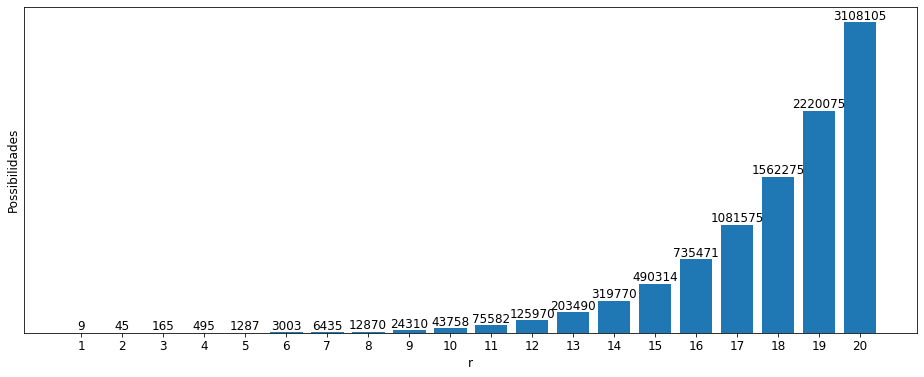

In [49]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x, y)
ax.bar_label(ax.containers[0], label_type='edge', fmt='%d')
plt.xlabel('r')
plt.ylabel('Possibilidades')
plt.xticks(range(1, 21))
plt.yticks([])
fig.show()

In [555]:
%%time
n = gerar_n(2, 5)

CPU times: total: 0 ns
Wall time: 3 ms


In [521]:
T = np.arange(0, 1440, 5) / 1440

for t in T[1:3]:
    print(t)

0.003472222222222222
0.006944444444444444


In [171]:
amostra_rests['TC'] = amostra_rests.apply(lambda x: (x['Término Entrega'] - x['Início Entrega']).total_seconds() / 60, axis=1)
amostra_rests['d_TC'] = amostra_rests.apply(lambda x: math.floor(x['TC'] / 5) + 1, axis=1)

In [503]:
amostra_rests['Início Preparo'].dt.floor('{}min'.format(10)).value_counts()

2023-01-10 20:10:00    11
2023-01-10 20:30:00    11
2023-01-10 21:00:00     9
2023-01-10 20:50:00     7
2023-01-10 19:20:00     7
                       ..
2023-01-10 01:00:00     1
2023-01-10 12:20:00     1
2023-01-10 00:10:00     1
2023-01-10 17:20:00     1
2023-01-10 11:10:00     1
Name: Início Preparo, Length: 83, dtype: int64

In [501]:
amostra_rests['delta_t'] = amostra_rests['Início Preparo'].dt.floor('{}min'.format(5))

In [176]:
L = amostra_rests['delta_t'].value_counts()[0]

In [177]:
m = amostra_rests['d_TC'].max()

In [487]:
def gerar_n2(n1, nnewst, L):
    n2 = [(i,) for i in range(1, L+1)]
    
    for yi, zi in zip(n1, nnewst):
        a_nnewst = np.sum(np.stack((yi[1], zi[1]), axis=1), axis=1)
        r = np.sum(a_nnewst, axis=1)

        for r, a_nnewst in zip(r, a_nnewst):
            if r > L: 
                continue

            n2[r-1] = n2[r-1] + (a_nnewst,)
        
    return n2

In [488]:
n2 = gerar_n2(n1, n, L)

In [489]:
n2

[(1, array([1, 0, 0, 0, 0, 0, 0, 0])),
 (2,
  array([1, 1, 0, 0, 0, 0, 0, 0]),
  array([0, 1, 1, 0, 0, 0, 0, 0]),
  array([0, 0, 1, 1, 0, 0, 0, 0]),
  array([0, 0, 0, 1, 1, 0, 0, 0]),
  array([0, 0, 0, 0, 1, 1, 0, 0]),
  array([0, 0, 0, 0, 0, 1, 1, 0]),
  array([0, 0, 0, 0, 0, 0, 1, 1]),
  array([2, 0, 0, 0, 0, 0, 0, 0])),
 (3,
  array([2, 1, 0, 0, 0, 0, 0, 0]),
  array([1, 1, 1, 0, 0, 0, 0, 0]),
  array([1, 0, 1, 1, 0, 0, 0, 0]),
  array([1, 0, 0, 1, 1, 0, 0, 0]),
  array([1, 0, 0, 0, 1, 1, 0, 0]),
  array([1, 0, 0, 0, 0, 1, 1, 0]),
  array([1, 0, 0, 0, 0, 0, 1, 1]),
  array([3, 0, 0, 0, 0, 0, 0, 0]),
  array([3, 0, 0, 0, 0, 0, 0, 0])),
 (4,
  array([2, 2, 0, 0, 0, 0, 0, 0]),
  array([0, 2, 2, 0, 0, 0, 0, 0]),
  array([0, 0, 2, 2, 0, 0, 0, 0]),
  array([0, 0, 0, 2, 2, 0, 0, 0]),
  array([0, 0, 0, 0, 2, 2, 0, 0]),
  array([0, 0, 0, 0, 0, 2, 2, 0]),
  array([0, 0, 0, 0, 0, 0, 2, 2]),
  array([1, 2, 1, 0, 0, 0, 0, 0]),
  array([1, 1, 1, 1, 0, 0, 0, 0]),
  array([1, 1, 0, 1, 1, 0, 0, 0]),

In [386]:
teste = [(i,) for i in range(1, L + 1)]

In [396]:
teste[1] + ([30, 29],)

(2, [30, 29])

In [311]:
pn = [1]

for px in pn:
    pn2 = probs_n2(nnewst, L, C, m, px, lamb, k, theta)
    print(pn2)

[0.01913418 0.00738982]
